# Phase Prediction of 1D Rydberg Atom Systems with Conditional Generative Models
Haoxiang Wang (hwang264@illinois.edu)

Work done as an applied scientist intern at Amazon Braket in 2022

In [1]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
import sys
from src.models.mlp import MLP
from src.eval import RydbergEvaluator
from src.eval.eval_rydberg import est_density_from_z_measurements,determine_phase_1D,est_order_param_1D,phase2img,est_phase_diagram,est_order_param_1D_fourier_from_measurements,est_order_param_1D_fourier,est_order_param_1D_from_measurements
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid
# Transformer
import argparse
from constants import *
from src.training.rydberg_trainers import RydbergConditionalTransformerTrainer
from src.models.transformer import init_conditional_transformer
from src.models.mlp import MLP


import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm,trange
import os

from src.utils import plot_phase_diagram

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## Rydberg Hamiltonian
This example is about trapped Rydberg atoms, a class of highly controllable neural atoms that can be used to build programmable Ising-type quantum simulators. In Ising-type quantum simulations, a Rydberg atom is effectively considered as a two-level system consisting of a ground state $| g \rangle$ (i.e., $|0\rangle$) and a highly-excited state $ | r\rangle$ (i.e., $|1 \rangle$) called Rydberg state. Rydberg atoms can be allocated on a plane and trapped by light tweezers. In \cite{Rydberg1D-51atoms}, Rydberg atoms are placed along a 1D lattice (i.e., a chain) equidistantly, while \cite{Rydberg2D-256atoms} allocates the atoms as a 2D square lattice. For either a 1D or 2D lattice of Rydberg atoms, denoting the nearest-neighbor distance of atoms $a$, the Hamiltonian of such a system can be described by
\begin{align}\label{eq:H-rydberg}
    H=\frac{\Omega}{2} \sum_{i} X_{i}-\Delta \sum_{i} N_{i}+\sum_{i<j}\left(\frac{V_{0}}{|\vec x_i- \vec x_j|}\right)^{6} N_{i} N_{j} ~,
\end{align}
where $\Omega$ is the Rabi frequency, $\Delta$ is the detuning of laser, $R_b$ is a constant, $\vec x_i$ is the location vector of the qubit $i$, and $N_i$ is the occupation number operator at site $i$, i.e., $N_i = |{r_i}\rangle \langle {r_i} |$


## Approximate Ground States via Adiabatic Evolution

The many-body ground state of a Rydberg Hamiltonian is typically obtained via \textit{adiabatic evolution}. 
Initially, each Rydberg atom is prepared in its ground state $|0\rangle$ (with high precision) such that the many-body state is $|0\dots 0\rangle$, which is the ground state of the Rydberg Hamiltonian with a large negative detuning $\Delta$ and zero-valued $\Omega$. Then, the detuning strength $\Delta$ is ramped up gradually to positive values, while the Rabi frequency is turned on (i.e., $\Omega > 0$). Clearly, the Hamiltonian of the Rydberg system is time-dependent according to a custom scheduler for $\Delta$ and $\Omega$. By the Adiabatic Theorem of quantum mechanics, we know as the time evolution process is slow enough, the quantum state of the system always stays closes to the ground state of the time-dependent Hamiltonian at any time step. Therefore, as the evolution process is sufficiently slow, we can end up with a prepared state that is approximately the ground state of the final Hamiltonian. 

## Load Simulation Results of Adiabatic Evolution

We conducted classical simulations for the adiabatic evolution of 1D Rydberg systems using [Bloqade.jl](https://github.com/QuEraComputing/Bloqade.jl/). The code for the simulation is presented in `rydberg/`.

Below, we load simulation data stored in `data/rydberg`.
+ For each simulation run of adiabatic evolution, we initiate a Rydberg lattice with a custom atom separation (i.e., $a$ in the Hamiltonian), and tune $\Delta, \Omega$ according to a preset scheduler. We take multiple time steps across the evolution, performing meausurements in the Z-basis, and save the measurement data locally.


### Scheduler for $\Delta, \Omega$
Here we show the schedulers we use for the adiabatic evolution simulation.

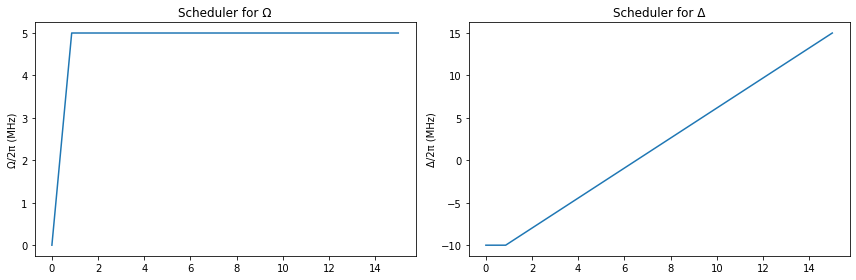

In [2]:
# Here we define a base schedule -- 
base_time = 3.5
ts = np.array([0,0.2,base_time])
omegas = np.array([0, 5, 5])
deltas = np.array([-10, -10, 15])
total_time = 15 # Total adiabatic evolution time of the Bloqade simulation
# We propotionally lengthen the schedules for Omega and Delta by time_ratio = total_time/base_time
time_ratio = total_time/base_time


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
ax1.plot(ts*time_ratio, omegas)
ax1.set_ylabel("Ω/2π (MHz)")
ax1.set_title("Scheduler for Ω")
ax2.plot(ts*time_ratio, deltas)
ax2.set_ylabel("Δ/2π (MHz)")
ax2.set_title("Scheduler for Δ")
fig.tight_layout()

Now we load simulated data.

In [3]:
n_qubits = 31 # number of Rydberg atoms in the 1D lattice

dim=1 # dimension of the system
ny = 1 # since we are working in 1D, this variable is fixed to 1
nx = n_qubits # effectively, we are working on a 2D lattice of dimensions nx*ny, where nx=n_qubits and ny=1.
z2_threshold=0.7 # threshold for the Z2 order parameter to determine a state is in Z2 phase
z3_threshold = 0.6 # threshold for the Z3 order parameter to determine a state is in Z3 phase

# We load simulation data for the lattice defined above with the adiabatic evolution scheduler preset above.
folder = f'data/rydberg/1D-Phase_{nx}/{float(np.round(total_time,2))}µs/'

# extra variables we want the conditional generative variable to condition on, except for "nx", "ny", "interaction_range".
# detuning = Delta/Omega
extra_variables = ["detuning",] 
meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=20, 
                                         var_name='interaction_range',variables = extra_variables) 
meta_dataset.est_order_params()
meta_dataset.info["phase" ] = determine_phase_1D(meta_dataset.info["Z2"], meta_dataset.info["Z3"],z2_threshold=z2_threshold,
                                                z3_threshold=z3_threshold
                                            )

## Phase Diagram of 1D Rydberg Lattice



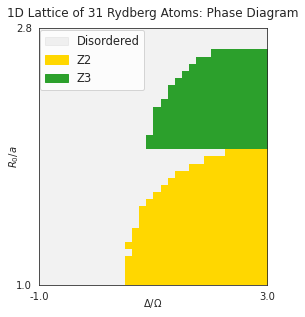

In [4]:
sns.set_style('white')
hue_order = ['Disordered','Z2','Z3']
plot_df = meta_dataset.info.copy()
plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] <= 2.8) & (plot_df['interaction_range'] > 1)]
fig = plot_phase_diagram(plot_df,title=f"1D Lattice of {n_qubits} Rydberg Atoms: Phase Diagram",hue_order = hue_order,
                        legend=True)

## Prepare Training Set

We split the phase diagram by grids (defined by `x_bins` and `y_bins`), and sample one point in each grid for training. Each point represents the ground state of one quantum system with the corresponding variables ($a,\Delta,\Omega$).

In [5]:

def prepare_train_set(meta_dataset, df=None, n_measurements:int = -1, x_bins=10,y_bins=10):
    train_set = {}
    if df is None: df = meta_dataset.info
    train_idxes, train_df = unif_sample_on_grid(df.copy(),x_bins=x_bins,y_bins=y_bins)#,x_range=(0.4,1.78),y_range=(1.4,2.4))
    # train_idxes = plot_df.index.values
    train_keys = meta_dataset.keys[train_idxes]
    train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set, train_idxes
    

In [6]:
# Decide to load a pretrained model or train from scratch
load_pretrained = True

In [7]:
if load_pretrained:
    # If loading a pretrained model, we need to also load the training set that 
    # it was trained on (specified by sampled indices of the meta_dataset.info DataFrame)
    train_idxes = np.load('logs/rydberg_1D/train_idxes.npy')
    train_set = pickle.load(open('logs/rydberg_1D/train_set.pkl','rb'))
else:
    # If train from scratch, we sample training data from the phase diagram specified by plot_df
    train_set, train_idxes = prepare_train_set(meta_dataset,df=plot_df)
    ## If you want to save this training set, you can un-comment the following lines:
    # np.save('logs/rydberg_1D/train_idxes.npy',train_idxes)
    # pickle.dump(train_set, open('logs/rydberg_1D/train_set.pkl','wb'))
    # pickle.dump(meta_dataset, open('logs/rydberg_1D/meta_dataset.pkl','wb'))

+ The darker points are the sysmtems used for training.

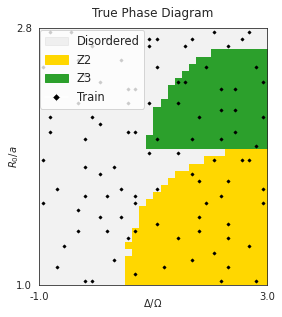

In [8]:
fig_true = plot_phase_diagram(plot_df,title=f"True Phase Diagram",train_idxes=train_idxes,hue_order=hue_order,
                            legend=True)

## Train a Conditional Generative Model

We first define some hyperparameters as follows

In [9]:
def parse_args(args=[]):
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='logs/rydberg/debug/')
    parser.add_argument('--dim',type=int,default=1)
    parser.add_argument('--nx',type=int,default=19)
    parser.add_argument('--ny',type=int,default=1)
    parser.add_argument('--total_time',type=float,default=6)
    parser.add_argument('--tf-arch', type=str, default='transformer_l4_d128_h4')
    parser.add_argument('--train-id', type=str, default="debug")
    parser.add_argument('--reps', type=int, default=1)
    parser.add_argument('--ns', type=int, default=800, help='number of samples per hamiltonian')
    parser.add_argument('--iterations', type=int, default=50000, help="training iterations")
    parser.add_argument('--eval-every', type=int, default=100)
    parser.add_argument('--eval-samples', type=int, default=10000, help='number of generated samples for evaluation')
    parser.add_argument('--k', type=int, default=1, help='number of buckets for median of means estimation')
    parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
    parser.add_argument('--verbose', type=int, default=1, choices=[0, 1])
    parser.add_argument('--epoch-mode', type=int, default=1, choices=[0, 1])
    parser.add_argument('--condition-mode', type=int, default=0, choices=[0, 1])
    parser.add_argument('--seed', type=int, default=None)
    return parser.parse_args(args)

def get_hyperparams(**kwargs):
    hparams = argparse.Namespace(
        lr=1e-3,
        wd=0,
        bs=512,
        dropout=0.0,
        lr_scheduler=WARMUP_COSINE_SCHEDULER,
        warmup_frac=0.,
        final_lr=1e-7,
        smoothing=0.0,
        use_padding=0,
        val_frac=0.25,
        cattn=0
    )

    for k, v in kwargs.items():
        setattr(hparams, k, v)

    return hparams
args = parse_args()
hparams = get_hyperparams()

### Select Device (GPU/CPU)
`gpu_idx < 0`: Use CPU

`gpu_idx > 0`: Use NVIDIA GPU

In [10]:
gpu_idx = 2
device = torch.device(f"cuda:{gpu_idx}") if gpu_idx >= 0 else torch.device('cpu')


In [11]:
num_outcomes = 2 # for rydberg systems
n_vars = len(list(train_set.keys())[0])


rng = np.random.default_rng(seed=args.seed)
# setup transformer
d_model = TF_ARCHS[args.tf_arch]['d_model']
n_head = TF_ARCHS[args.tf_arch]['n_head']
n_layers = TF_ARCHS[args.tf_arch]['n_layers']
assert d_model % n_head == 0, 'd_model must be integer multiple of n_head!'

We construct a MLP (fully-connected net) as the encoder and a transformer as the generative model, and then train the model

In [12]:
encoder = MLP(input_size=n_vars, output_size=d_model, 
              n_layers=1, hidden_size=128, activation='ELU', 
              input_layer_norm=False,
              output_batch_size=None, device=device,
             output_factor=1.)

transformer = init_conditional_transformer(
        n_outcomes=num_outcomes,
        encoder=encoder,
        n_layers=n_layers,
        d_model=d_model,
        d_ff=4 * d_model,
        n_heads=n_head,
        dropout=hparams.dropout,
        version=hparams.use_padding,
        use_prompt=False, #***
)

In [13]:
trainer = RydbergConditionalTransformerTrainer(model=transformer,
                                  train_dataset=train_set,
                                  test_dataset=None,
                                  iterations=args.iterations,
                                  lr=hparams.lr,
                                  final_lr=hparams.final_lr,
                                  lr_scheduler=hparams.lr_scheduler,
                                  warmup_frac=hparams.warmup_frac,
                                  weight_decay=hparams.wd,
                                  batch_size=hparams.bs,
                                  rng=rng,
                                  smoothing=hparams.smoothing,
                                  eval_every=args.eval_every,
                                  transfomer_version=hparams.use_padding,
                                  device=device)
model_name = f'transformer_nq-{n_qubits}_iter-{args.iterations//1000}k'
print('Training iterations:', args.iterations)

Training iterations: 50000


In [14]:
if load_pretrained:
    ckpt_path = f'logs/rydberg_1D/{model_name}.pth'
    transformer = torch.load(ckpt_path)
    print(f'Loaded trained model from {ckpt_path}')
else:
    trainer.train()
    torch.save(transformer,f'logs/rydberg_1D/{model_name}.pth') # You can save the trained model

Loaded trained model from logs/rydberg_1D/transformer_nq-31_iter-50k.pth


For every point in the phase diagram, we use the conditional generative model to generate `n_gen_samples` measurements, and then determine the phase by order parameters.

The predicted order parameters & phases are saved in the DataFrame `test_df`

In [15]:
n_gen_samples = 1000
order_params = ['Z2','Z3']

**Note.** the measurement generation of the trained model has randomness -- so each run may give slightly different results

In [16]:
torch.manual_seed(0) # Set seed to ensure reproduction
torch.cuda.manual_seed(0)
test_df = plot_df.copy()
test_df[order_params] = np.nan
densities = {}
transformer.eval()
for idx in tqdm(test_df.index, "Test System"):
    key = meta_dataset.keys[idx]
    condition = torch.from_numpy(np.array([key])).float()
    gen_samples = transformer.sample_batch(cond_var=condition,batch_size=n_gen_samples,
                                               num_qubits=n_qubits)
    density = gen_samples.mean(axis=0)
    densities[idx] = density
    for order_param in order_params:
        test_df.loc[idx, order_param] = est_order_param_1D_from_measurements(gen_samples,order_param=order_param,
                                                                             nx=n_qubits)
test_df['phase'] = determine_phase_1D(test_df['Z2'].values, test_df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
test_df = test_df.sort_values(['phase'])

Test System:   0%|          | 0/1152 [00:00<?, ?it/s]

Now we can compare the phase diagram predicted by our trained model against the ground truth phase diagram.

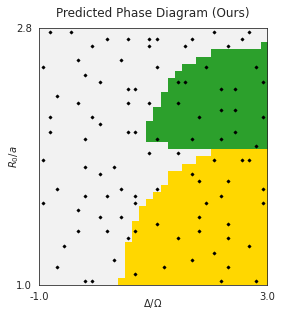

In [17]:
fig_pred = plot_phase_diagram(test_df,title=f"Predicted Phase Diagram (Ours)",
                              train_idxes=train_idxes,hue_order=hue_order,)

Let us exclude the training points over the phase diagram -- to obtain a test set for quantative evaluation

In [18]:
test_idxes = np.sort(plot_df.index[~np.isin(plot_df.index,train_idxes)])

The prediction error of our model on test points in the phase diagram

In [19]:
pred_order_params = test_df.loc[test_idxes][order_params].values
true_order_params = meta_dataset.info.loc[test_idxes][order_params].values 
err_CGM = np.sqrt(np.mean((pred_order_params - true_order_params)**2))
err_CGM

0.019946439887680027

Classification accuracy on test points

In [20]:
def compute_acc(pred_df,true_df,idxes=None):
    if idxes is not None:
        pred_df = pred_df.loc[idxes]
        true_df = true_df.loc[idxes]
    V = pred_df['phase'].values == true_df['phase'].values
    clf_acc = np.mean(V)
    return clf_acc

In [21]:
compute_acc(test_df,plot_df,test_idxes)

0.9828897338403042

In [22]:
from src.models.kernels import build_dirichlet_kernel,build_NTK
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

Build training data and test data for kernels

In [23]:
train_keys = list(train_set.keys())
base_kwargs = {}
Xs,Xs_test,Ys,Ys_test = [],[],[],[]
for key, measurements in train_set.items():
    x = np.array(key)
    density = np.mean(measurements,axis=0)
    y = [est_order_param_1D_from_measurements(measurements,order_param=order_param,**base_kwargs) for order_param in order_params]
    # y = density
    Xs.append(x)
    Ys.append(y)
Xs,Ys = np.array(Xs),np.array(Ys)

scaler = MinMaxScaler()#Normalizer()
# scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)
Xs_test = scaler.transform(meta_dataset.keys[test_idxes])
Ys_test = meta_dataset.info.loc[test_idxes][order_params].values

#### Dirichlet Kernel

In [24]:
train_dirichlet_kernel = build_dirichlet_kernel(Xs)
test_dirichlet_kernel = build_dirichlet_kernel(Xs_test)

In [25]:
C_dir = 1e1
clf_dir = KernelRidge(kernel='linear',alpha=1/(2*C_dir)).fit(train_dirichlet_kernel,Ys)

In [26]:
pred_dirichlet = clf_dir.predict(test_dirichlet_kernel)
err_dirichlet = np.sqrt(np.mean((pred_dirichlet - Ys_test)**2))

In [27]:
print('Prediction Error of Order Parameters (in RMSE):', err_dirichlet)

Prediction Error of Order Parameters (in RMSE): 0.1137680379423856


#### Gaussian Kernel (i.e., RBF Kernel)

In [28]:
C_rbf = 4e8
clf_rbf = KernelRidge(kernel='rbf',alpha=1/(2*C_rbf)).fit(Xs,Ys)
pred_rbf = clf_rbf.predict(Xs_test)
err_rbf = np.sqrt(np.mean((pred_rbf - Ys_test)**2))

In [29]:
print('Prediction Error of Order Parameters (in RMSE):', err_rbf)

Prediction Error of Order Parameters (in RMSE): 0.05505370764087319


#### Neural Tangent Kernel (NTK)

In [30]:
# We found the GPU version of Jax doesn't give stable NTK results when the regularization is very small, 
# i.e., the coefficient C is large.
# So we let Jax to run on CPU only when computing the NTK
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [31]:
C_ntk = 1000
NTK, ntk_pred_fn = build_NTK(Xs,Ys,C=C_ntk,layers=50,normalize=False,activation='Erf')
pred_ntk = ntk_pred_fn(Xs_test)
err_ntk = np.sqrt(np.mean((pred_ntk - Ys_test)**2))

In [32]:
print('Prediction Error of Order Parameters:', err_ntk)

Prediction Error of Order Parameters: 0.053431481429118494


Obtain predictions of kernel methods for all points in the phase diagram

In [33]:
df = plot_df.copy()
# df = df.loc[df[xlabel] > 0]
for order_param in order_params:
    df[order_param] = np.nan
keys = meta_dataset.keys[df.index.values]
xs = scaler.transform(keys)

df[order_params] = clf_rbf.predict(xs)
df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
df = df.sort_values(['phase'])
df_rbf = df.copy()

df = plot_df.copy()
df[order_params] = clf_dir.predict(build_dirichlet_kernel(xs))
df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
df = df.sort_values(['phase'])
df_dir = df.copy()

In [34]:
df = plot_df.copy()
df[order_params] = ntk_pred_fn(xs)
df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
df = df.sort_values(['phase'])
df_ntk = df.copy()

Classification Accuracy

In [35]:
print('Dirichlet Kernel: {:.5f}'.format(compute_acc(df_dir, plot_df,test_idxes)))
print('Gaussian Kernel: {:.5f}'.format(compute_acc(df_rbf, plot_df,test_idxes)))
print('NTK: {:.5f}'.format(compute_acc(df_ntk, plot_df,test_idxes)))

Dirichlet Kernel: 0.84791
Gaussian Kernel: 0.95057
NTK: 0.95817


Predicted Phase Diagrams

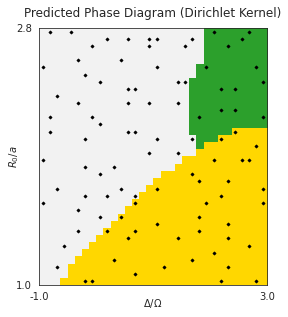

In [36]:
fig_dir = plot_phase_diagram(df_dir,title=f"Predicted Phase Diagram (Dirichlet Kernel)",train_idxes=train_idxes,
                            hue_order = ['Disordered','Z2','Z3'])

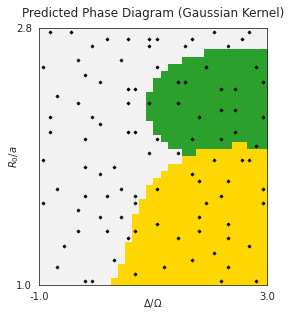

In [37]:
fig_rbf = plot_phase_diagram(df_rbf,title=f"Predicted Phase Diagram (Gaussian Kernel)",train_idxes=train_idxes,
                            hue_order = ['Disordered','Z2','Z3'],)

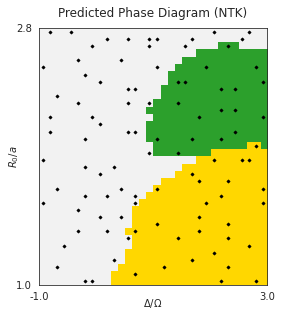

In [38]:
fig_ntk = plot_phase_diagram(df_ntk,title=f"Predicted Phase Diagram (NTK)",train_idxes=train_idxes,
                            hue_order = ['Disordered','Z2','Z3'])

Save Figures (Optional)

In [39]:
fig_pred.tight_layout()
fig_true.tight_layout()
fig_rbf.tight_layout()
fig_ntk.tight_layout()
fig_pred.savefig('figs/paper/1D-phase-ours.pdf')
fig_true.savefig('figs/paper/1D-phase-true.pdf')
fig_rbf.savefig('figs/paper/1D-phase-rbf.pdf')
fig_ntk.savefig('figs/paper/1D-phase-ntk.pdf')